In [1]:
import csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as mp
import tensorflow as tf
import keras
from keras.models import model_from_json

Using TensorFlow backend.
/home/oscar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/oscar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/oscar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/oscar/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:
bins = 128
seedmax = 60 # opens seed files 0 - 19. Lost too much data due to kernel crashes, so these got broken up
trainx = []
trainy = []
validx = []
validy = []

In [3]:
#This is not a ... pythonic [barf]... way of reading data, but python is stupid about pointers, so deal with it
for i in range(seedmax):
    with open('test_pots'+str(i)+'.csv', 'r') as csvfile:
        flurg = csv.reader(csvfile)
        for row in flurg:
            trainx.append([float(num) for num in row])
    with open('test_out'+str(i)+'.csv', 'r') as csvfile:
        flurg = csv.reader(csvfile)
        for row in flurg:
            trainy.append([float(num) for num in row])
    with open('valid_pots'+str(i)+'.csv', 'r') as csvfile:
        flurg = csv.reader(csvfile)
        for row in flurg:
            validx.append([float(num) for num in row])
    with open('valid_out'+str(i)+'.csv', 'r') as csvfile:
        flurg = csv.reader(csvfile)
        for row in flurg:
            validy.append([float(num) for num in row])

In [4]:
trainx = np.array(trainx)
trainy = np.array(trainy)
validx = np.array(validx)
validy = np.array(validy)

In [29]:
def plot(x, y, model, normalize=True):
    mp.plot(model.predict(np.array([x]))[0]/np.pi, label='prediction')
    #mp.plot(np.array(y)/np.pi)
    if normalize:
        mp.plot([x[i]/max(x) for i in range(bins - 1)], label='potential')
    else:
        mp.plot([x[i] for i in range(bins - 1)], label='potential')
    mp.plot(np.array(y)/np.pi, label='solution')
    mp.xticks([i for i in range(127) if i%20 == 0], [round((((x)/(128/np.pi))-np.pi/2),2) for x in range(1,128) if x%20 == 1])
    mp.xlabel("x")
    mp.legend()
    mp.show()
    
def plot_err(x,y,model):
    mp.semilogy((np.abs(model.predict(np.array([x]))[0]/np.pi - np.array(y)/np.pi)))
    mp.xticks([i for i in range(127) if i%20 == 0], [round((((x)/(128/np.pi))-np.pi/2),2) for x in range(1,128) if x%20 == 1])
    mp.xlabel("x")
    mp.ylabel("error")
    mp.show()

In [6]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [7]:
model = loaded_model

In [8]:
pred = [model.predict(np.array([x]))[0] for x in validx]

In [9]:
errors = [np.mean(np.abs(pred[i] - validy[i])) for i in range(len(pred))]

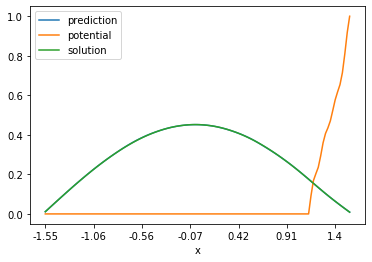

0.003316164016723633


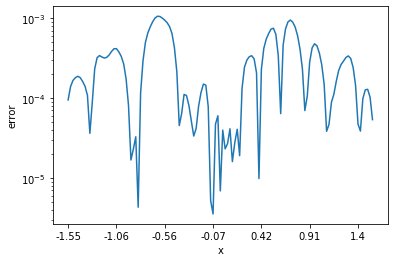

In [10]:
idxmin = errors.index(min(errors))
plot(validx[idxmin], validy[idxmin], model)
print(max(model.predict(np.array([validx[idxmin]]))[0] - validy[idxmin]))
plot_err(validx[idxmin], validy[idxmin], model)

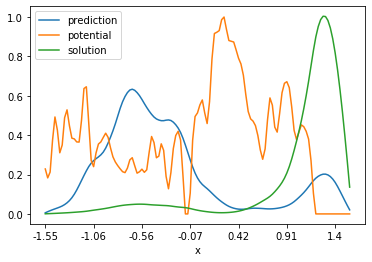

1.8390917778015137


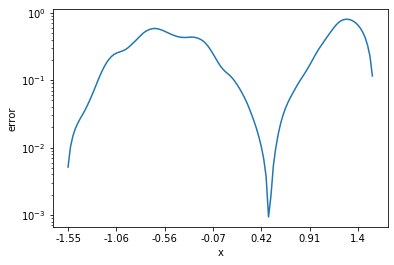

In [11]:
idxmax = errors.index(max(errors))
plot(validx[idxmax], validy[idxmax], model)
print(max(model.predict(np.array([validx[idxmax]]))[0] - validy[idxmax]))
plot_err(validx[idxmax], validy[idxmax], model)

In [12]:
def subexp(expon):
    return np.power(abs(np.log(np.random.uniform())),expon)

def generatepot(style,param): #0=step,1=linear,2=fourier; 0-1 "jaggedness" scale
    mu = 1. + bins*param #mean number of jump points for styles 0 + 1
    forxp = 2.5 - 2*param #fourier exponent for style 2
    scale = 5.0*(np.pi*np.pi*0.5) # energy scale
    if style < 2:
        dx = bins/mu
        xlist = [-dx/2]
        print(xlist[-1])
        while xlist[-1] < bins:
            xlist.append(xlist[-1]+dx*subexp(1.))
        vlist = [scale*subexp(2.) for k in range(len(xlist))]
        k = 0
        poten = []
        for l in range(1,bins):
            while xlist[k+1] < l:
                k = k + 1
            if style == 0:
                poten.append(vlist[k])
            else:
                poten.append(vlist[k]+(vlist[k+1]-vlist[k])*(l-xlist[k])/(xlist[k+1]-xlist[k]))
    else:
        sincoef = [(2*np.random.randint(2)-1.)*scale*subexp(2.)/np.power(k,forxp) for k in range(1,bins//2)]
        coscoef = [(2*np.random.randint(2)-1.)*scale*subexp(2.)/np.power(k,forxp) for k in range(1,bins//2)]
        zercoef = scale*subexp(2.)
        poten = np.maximum(np.add(np.add(np.matmul(sincoef,sinval),np.matmul(coscoef,cosval)),zercoef),0).tolist()
    return poten

seed = 19
np.random.seed(seed)
bins = 128 #dx = 1/bins; actual number of columns saved = bins-1, because 1st and last are 0
npots = 200 #ends up being 3*this*(validnth-1)/validnth
validnth = 5 #every nth sample func is saved as validation
sinval = np.sin([[np.pi*i*j/bins for i in range(1,bins)] for j in range(1,bins//2)])
cosval = np.cos([[np.pi*i*j/bins for i in range(1,bins)] for j in range(1,bins//2)])
sqrt2 = np.sqrt(2)

defgrdstate = tf.constant([sqrt2*np.sin(i*np.pi/bins) for i in range(1,bins)])
psi = tf.Variable(defgrdstate)
zerotens = tf.zeros([1])
psil = tf.concat([psi[1:],zerotens],0)
psir = tf.concat([zerotens,psi[:-1]],0)
renorm = tf.assign(psi,tf.divide(psi,tf.sqrt(tf.reduce_mean(tf.square(psi)))))
optimzi = tf.train.GradientDescentOptimizer(0.0625/bins)
reinit = tf.assign(psi,defgrdstate)
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

def get_pot(vofx):
    #vofx = generatepot(j,(1.*i)/npots)
    #print(vofx)
    energy = tf.reduce_mean(tf.subtract(tf.multiply(tf.square(psi),tf.add(vofx,1.*bins*bins)),
                                        tf.multiply(tf.multiply(tf.add(psil,psir),psi),0.5*bins*bins)))
    training = optimzi.minimize(energy)
    sess.run(reinit)
    for t in range(20000):
        sess.run(training)
        sess.run(renorm)
    return sess.run(psi).tolist()

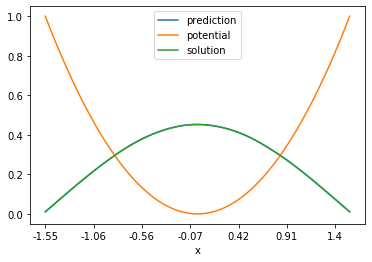

0.0013799435754661138
0.0005031536095611331


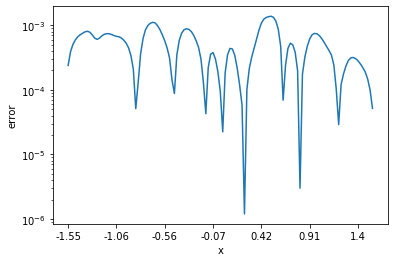

In [13]:
#x**2
vofx = [(((x)/(128/np.pi))-np.pi/2)**2 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

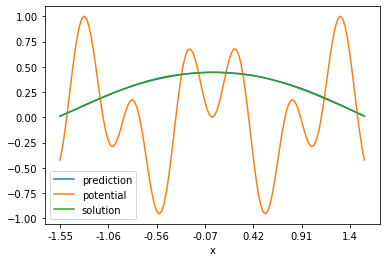

0.006597604261211976
0.0032598893007271448


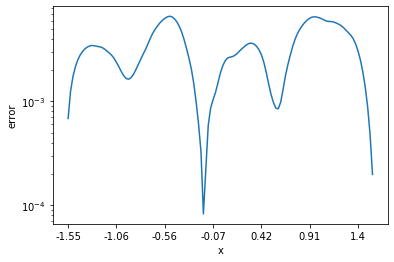

In [14]:
#sen(12x) + cos(5x)
vofx = [np.sin(((12*x)/(128/np.pi))-np.pi/2) + np.cos(((5*x)/(128/np.pi))-np.pi/2) for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

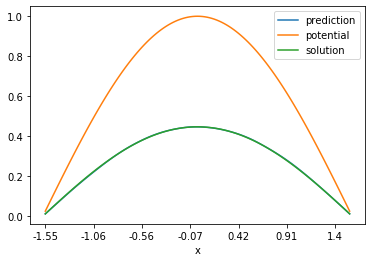

0.0024683670890660314
0.000879460913858069


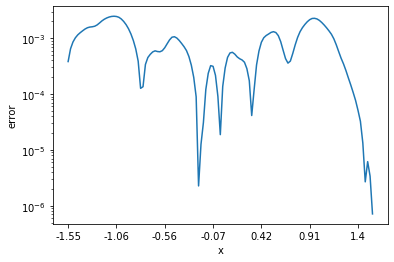

In [15]:
#cos(x)
vofx = [np.cos(((x)/(128/np.pi))-np.pi/2) for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

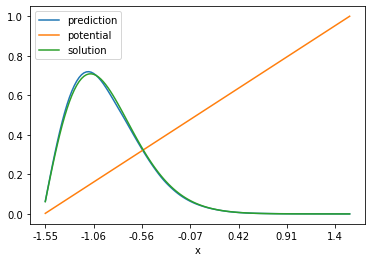

0.021997495392519828
0.005366245639345947


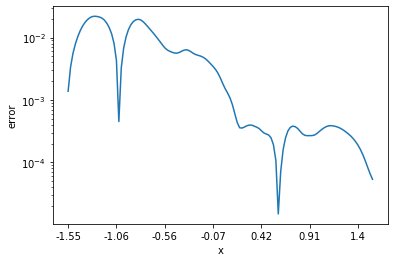

In [16]:
#100*x
vofx = [(((100*x)/(128/np.pi))-np.pi/2) for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

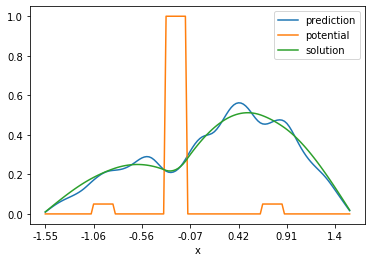

0.05615790541326393
0.01914579346968846


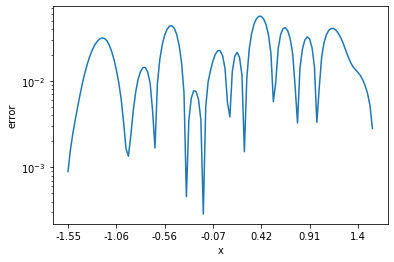

In [17]:
#escalera
vofx = [5.0 if 20 < x < 30 or 90 < x < 100 else 100.0 if 50 < x < 60 else 0.0 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

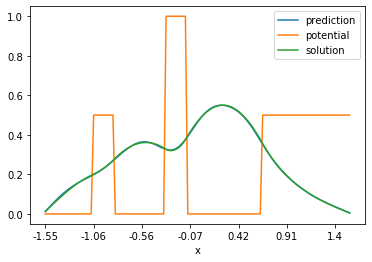

0.006714793866679031
0.0024922781554952114


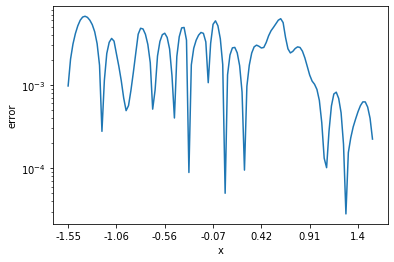

In [18]:
#escalera
vofx = [50.0 if 20 < x < 30 or 90 < x < 200 else 100.0 if 50 < x < 60 else 0.0 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

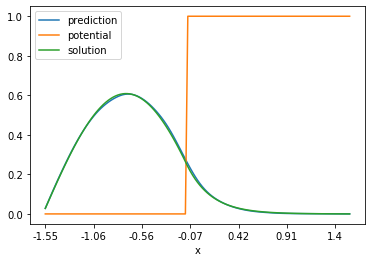

0.015310088196919536
0.0037772314810072395


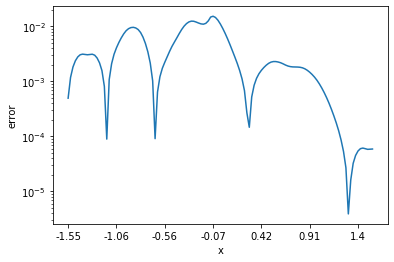

In [19]:
#sin(x) then 20
#vofx = [np.sin(((x)/(128/np.pi))-np.pi/2) if x < 60 else 20.0 for x in range(1,128)]
#0 then 20
vofx = [0.0 if x < 60 else 100.0 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

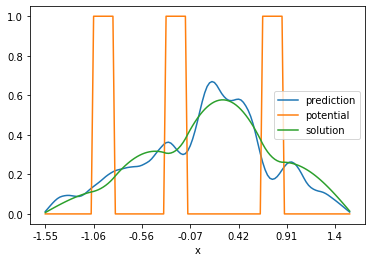

0.11871546300231961
0.039631747627082804


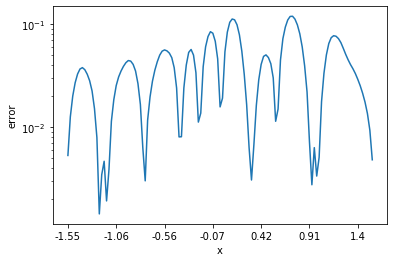

In [20]:
#escalera
vofx = [100.0 if 20 < x < 30 or 90 < x < 100 else 100.0 if 50 < x < 60 else 0.0 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

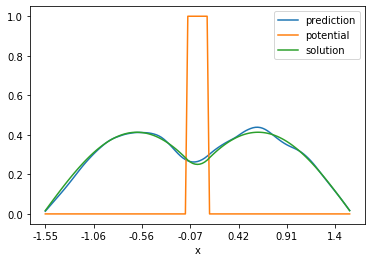

0.025334062834364512
0.008539150855742632


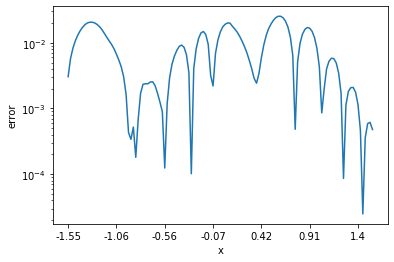

In [21]:
#efecto tunel 1
vofx = [100.0 if (59 < x < 69) else 0 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

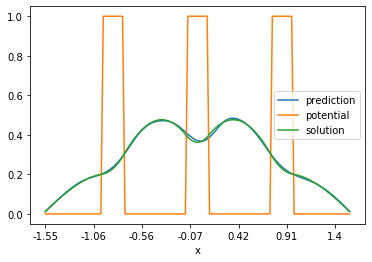

0.01761870998308923
0.004757444582295719


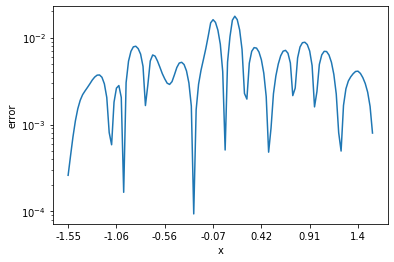

In [22]:
#efecto tunel 3
vofx = [100.0 if (59 < x < 69) or(24 < x < 34) or (94 < x < 104) else 0 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

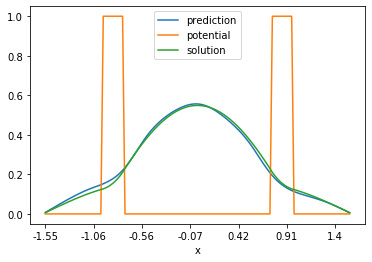

0.026557099308856053
0.010887509113881384


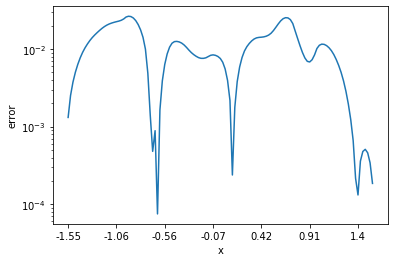

In [23]:
#efecto tunel 2
vofx = [100.0 if (24 < x < 34) or (94 < x < 104) else 0 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

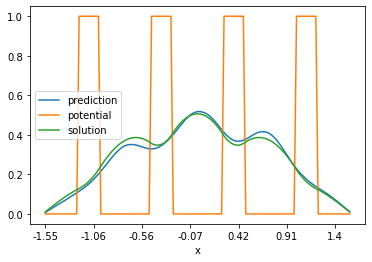

0.04260126632190964
0.016164594372450377


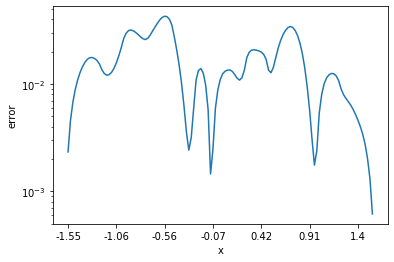

In [24]:
#efecto tunel 4
vofx = [100.0 if (14 < x < 24) or (44 < x < 54) or (74 < x < 84) or (104 < x < 114) else 0 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

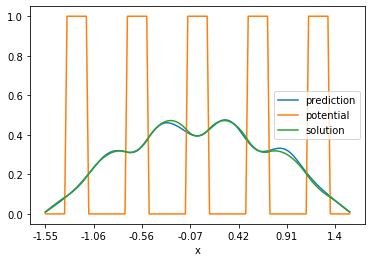

0.02152931551775733
0.005636505777533978


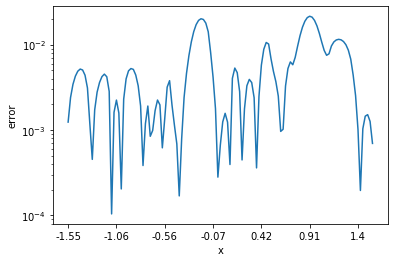

In [25]:
#efecto tunel 5
vofx = [100.0 if (9 < x < 19) or (34 < x < 44) or (59 < x < 69) or (84 < x < 94) or (109 < x < 119) else 0 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

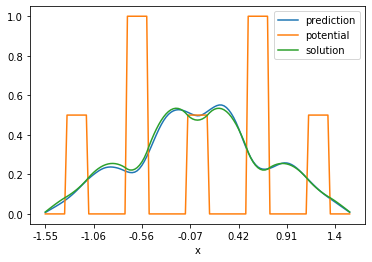

0.030521456159957994
0.01038982932625752


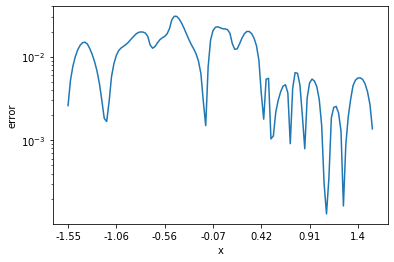

In [26]:
#efecto tunel 5.2
vofx = [100.0 if (9 < x < 19) or (59 < x < 69) or (109 < x < 119) else 200 if (34 < x < 44) or (84 < x < 94) else 0 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

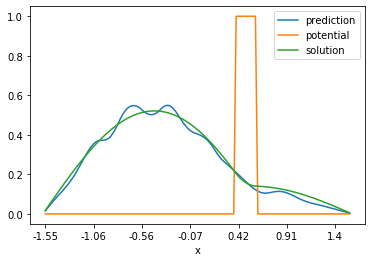

0.05332214920264616
0.01897477378474682


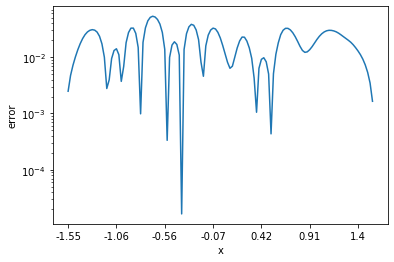

In [27]:
#efecto tunel 1.2
vofx = [100.0 if (79 < x < 89) else 0 for x in range(1,128)]
plot(vofx, get_pot(vofx), model)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)

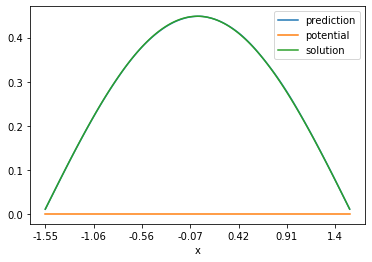

0.0013124095575600125
0.000538968870341658


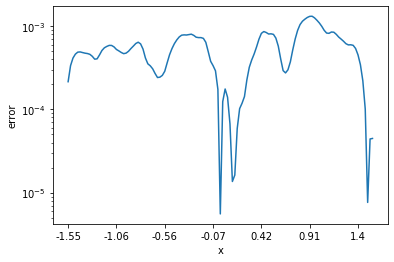

In [30]:
#potencial 0
vofx = [0.0001 for x in range(1,128)]
plot(vofx, get_pot(vofx), model, normalize=False)
print(max(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
print(np.mean(np.abs(model.predict(np.array([vofx]))[0]/np.pi - np.array(get_pot(vofx))/np.pi)))
plot_err(vofx, get_pot(vofx), model)